# Predict the predicted improvement due to thrombolysis 
For the patients in the training set calculate the SHAP improvement due to IVT - will use this as the target feature for the XGBoost model.

### Plain English summary

Fit an XGBoost model to predict the predicted improvement due to thrombolysis, using 7 features: "prior_disability", "stroke_severity", "stroke_team", "age", "onset_to_thrombolysis_time", "any_afib_diagnosis", "precise_onset_known".

The target feature (the predicted improvement due to thrombolysis) is calculated in notebook 100. Calculated for the patients in the teset set that had thrombolysis, using the difference between the SHAP vlaues for feature onset_to_thrombolyiss_time when patients then didn't have treatment (setting feature value to -100)

We build a XGBoost regression model to predict the predicted effect of thrombolysis treatment on disability discharge. We build a SHAP model to identify what patient features improve the benefit from thrombolysis, and which reduce the benefit from thromboylsis. We might also want to just look at characteristics of patients with a negative treatment effect, vs those with a positive treatment effect.

### Model and data
Train an XGBoost model to predict the predicted improvement due to thrombolysis.

Target feature calculated in notebook 100.

Use the same 7 input features as in the disability outcome model (as it's only those features that created the target feature): 1) prior_disability, 2) stroke_severity, 3) stroke_team, 4) age, 5) onset-to-thrombolysis-time, 6) any_afib_diagnosis 7) precise_onset_known

Use just the first kfold split.


### Aims


### Observations




#### Further work

#### Resources
Using code from https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/02b_xgb_combined_fit_accuracy_key_features_separate_k_fold.ipynb

and https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03_xgb_combined_shap_key_features.ipynb

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from dataclasses import dataclass

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

import pickle
import shap

from os.path import exists

import time
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression


Report the time duration to run notebook

In [2]:
start_time = time.time()

Use just the first k-fold split, and define the target feature

In [3]:
k = 0
target_feature = 'predicted_shap'

Select the features for the model

In [4]:
selected_features = ["prior_disability", "stroke_severity", "stroke_team", 
                     "age", "onset_to_thrombolysis_time", "any_afib_diagnosis", 
                     "precise_onset_known"]
n_features = len(selected_features)

## Set up paths and filenames

Use os.path.join() to create filenames. So define folders without trailing forward slash, and include all characters in file names.

In [5]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output/kfold_5fold'
    model_text: str = f'xgb_{n_features}_features_1_kfold_ivt_improvement'
    notebook: str = '110_'

paths = Paths()

Create output folders if needed

In [6]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

## Import data

Import the first kfold split

In [7]:
# Read in test set, restrict to chosen features, & store
#filename = os.path.join(paths.data_read_path, '03_train_0.csv')
#train = pd.read_csv(filename)
#train = train[selected_features]

filename = os.path.join(paths.data_read_path, '03_test_0.csv')
test = pd.read_csv(filename)
test = test[selected_features]

Only keep patients that received thrombolysis (to match the data that we'll read in that contains the target feature: improvement due to thrombolysis)

In [8]:
# mask the patients in test set that recieve IVT
mask_get_ivt = test["onset_to_thrombolysis_time"] > -100
test = test[mask_get_ivt]

### One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [9]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    Converts a categorical feature into a one hot encoded feature
    
    Args:
        df [dataframe]: training or test dataset
        feature_name [str]: feature to convert to one hot encoding
        prefix [str]: string to use on new feature

    Return:
        df [dataframe]: One hot encoded representation of the feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [10]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

In [12]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    if feature in selected_features:
#        train = convert_feature_to_one_hot(train, feature, prefix)
        test = convert_feature_to_one_hot(test, feature, prefix)

Feature names with one hot encoding

In [13]:
features_ohe = list(test)
n_features_ohe = len(features_ohe)

print(f"There are {n_features} original features (before one-hot encoding)")
print(f"There are {n_features_ohe} features (after one-hot encoding)")

There are 7 original features (before one-hot encoding)
There are 124 features (after one-hot encoding)


Read in the data that contains the target feature: improvement due to IVT use (created in notebook 100)

This only contains patietns that had thrombolysis (so will need to select only those patients in the input feature dataset)

In [14]:
filename = os.path.join(paths.data_save_path,
                        (f"100_xgb_{n_features}_features_1_kfold_binary" + 
                        "_improvement_due_to_ivt.csv"))

df_test_ivt_and_no_ivt_shap = pd.read_csv(filename)

View file (has each patient repeated 6 times, once for each mRS threshold)

In [26]:
y_test = df_test_ivt_and_no_ivt_shap["shap_ivt_improvement"]
y_test

0        0.667180
1        0.502605
2        0.652915
3        0.159988
4        0.444915
           ...   
41377    0.663825
41378   -0.211177
41379    0.113321
41380    0.185595
41381    0.343665
Name: shap_ivt_improvement, Length: 41382, dtype: float64

Setup test by repeating the rows 6 times (to match the target feature)

In [30]:
X_test = test.copy(deep=True)

for t in range(5):
    X_test = pd.concat([X_test, test]).reset_index(drop=True)

# KP YOU ARE HERE.

# CONTINUE IF WANT THIS ANALYSIS - CHECK WITH MIKE

## Load XGBoost model

In [ ]:
def fit_xgboost(filename, X_train, y_train):
    """
    Given the filename, either load if the model exists (saved as a pickle), 
    else train a new model.

    Args:
        filename [string]: where xgboost model is saved
        X_train [dataframe]: feature values
        y_train [dataframe]: target feature
        
    Returns:
        model [object]: xgboost classifier model

    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:
        # Define and Fit model
        model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5,
                              tree_method='gpu_hist')
        model.fit(X_train, y_train)

        # Save using pickle
        with open(filename, 'wb') as filehandler:
            pickle.dump(model, filehandler)

    return(model)

In [ ]:
def calculate_shap_extended(shap_extended_filename, explainer_filename, model, 
                            X_data, X_background):
    """
    TreeExplainer is a fast and exact method to estimate SHAP values for tree 
    models and ensembles of trees. Using this we can calculate the SHAP values.

    Either load from pickle (if file exists), or calculate.

    Args:
        model [xgboost classification model object]: xgboost object
        k [integer]: kfold number
        X_train [dataframe]: training set (used as background data)
        X_test [dtaframe]: test set (to calculate the SHAP values for)

    Return:
        shap_values_extended [dictionary]: the extended shap values (contains 
                    .values, .base, and .data)
        
    """    
    # Check if exists
    file_exists = exists(shap_extended_filename)

    if file_exists:
        # Load SHAP values extended
        with open(shap_extended_filename, 'rb') as filehandler:
            shap_values_extended = pickle.load(filehandler)
    else:
        # Calculate SHAP values extended

        # Set up explainer using the model and feature values from training set
        explainer = shap.TreeExplainer(model, X_background)

        # Get (and store) Shapley values along with base and feature values
        shap_values_extended = explainer(X_data)

        # Save explainer using pickle
        with open(explainer_filename, 'wb') as filehandler:
            pickle.dump(explainer, filehandler)
            
        # Save shap values extendedr using pickle
        with open(shap_extended_filename, 'wb') as filehandler:
            pickle.dump(shap_values_extended, filehandler)
            
    return(shap_values_extended)

# NEED TO WORK OUT WHAT HAPPENONG ONWARDS, AND IF NEED FOR THE GITHUB REPOSITORY

Calculate SHAP values for the improvement due to thrombolysis for the patients in the training set (want the SHAP improvement due to IVT for the training set - will use this as the target feature in a later XGBoost model)

In [ ]:
model_threshold = []

for t in range(6):
    binary_target_feature = f'binary_{t}'
    y_train = convert_feature_to_binary(y_train_orig, t)
    y_test = convert_feature_to_binary(y_test_orig, t)

    # Model filename
    filename = os.path.join(paths.model_save_path, 
                            (paths.notebook + paths.model_text + '_' +
                             str(t) + '.p'))
    
    model_threshold.append()
    

In [ ]:
X_train_no_ivt = X_train.copy(deep=True)
X_train_no_ivt["onset_to_thrombolysis_time"] = -100
shap_values_train_no_ivt_threshold = []

# Loop through thresholds folds. Get model and get SHAP for patients not getting IVT
for t in range(6):
    model = model_threshold[t]
    
    # Set up explainer using the model and feature values from training set
    explainer = shap.TreeExplainer(model, X_train)

    # Get (and store) Shapley values along with base and feature values
    shap_values_train_extended_no_ivt = explainer(X_train_no_ivt)
    shap_values_train_no_ivt_threshold.append(shap_values_train_extended_no_ivt.values)

# Create a dataframe for the patients in the training set that got IVT (as need the onset to treatment time). 
# A row per patient. Store the features needed for the plot, and the SHAP for getting IVT at their onset to treatment time, and their SHAP if not get IVT.
df_train_ivt_and_no_ivt_shap = create_df_with_without_ivt(X_train,
                shap_values_train_threshold, shap_values_train_no_ivt_threshold)
df_train_ivt_and_no_ivt_shap.head()

 99%|===================| 133598/134677 [01:28<00:00]        

IndexError: list index out of range

In [ ]:
mask_train_get_ivt = X_train["onset_to_thrombolysis_time"] > -100
X_train_get_ivt = X_train[mask_train_get_ivt]
mask_test_get_ivt = X_test["onset_to_thrombolysis_time"] > -100
X_test_get_ivt = X_test[mask_test_get_ivt]

In [ ]:
t = 0

# get the target feature: the SHAP for improvement due to IVT 
# (wrt the mRS threshold)
mask_train_mrs = df_train_ivt_and_no_ivt_shap["mRS_threshold"] == t
y_train_shap_improvement_from_ivt  = df_train_ivt_and_no_ivt_shap["shap_ivt_improvement"][mask_train_mrs]
mask_test_mrs = df_test_ivt_and_no_ivt_shap["mRS_threshold"] == t 
y_test_shap_improvement_from_ivt = df_test_ivt_and_no_ivt_shap["shap_ivt_improvement"][mask_test_mrs]

In [ ]:
df_test_ivt_and_no_ivt_shap[mask_test_mrs]["patient_id"]

0           6
1           7
2          12
3          15
4          16
        ...  
6892    33652
6893    33656
6894    33657
6895    33666
6896    33669
Name: patient_id, Length: 6897, dtype: object

In [ ]:
r_square_threshold = []
roc_auc_ovr_threshold = []
accuracy_threshold = []
error_within_one_threshold = []
feature_importance_threshold = []
y_probs_threshold = []
y_pred_threshold = []
model_threshold = []
shap_values_extended_si_threshold = []
shap_values_si_threshold = []

# Loop through mRS thresholds
for t in range(6):

    # set string for output
    binary_target_feature = f'binary_{t}'

    # get the target feature: the SHAP for improvement due to IVT 
    # (wrt the mRS threshold)
    mask_train_mrs = df_train_ivt_and_no_ivt_shap["mRS_threshold"] == t
    y_train_shap_improvement_from_ivt = df_train_ivt_and_no_ivt_shap["shap_ivt_improvement"][mask_train_mrs]
    X_train_ivt = X_train[mask_train_mrs]
    mask_test_mrs = df_test_ivt_and_no_ivt_shap["mRS_threshold"] = t 
    y_test_shap_improvement_from_ivt = df_test_ivt_and_no_ivt_shap["shap_ivt_improvement"][mask_test_mrs]

    #check the patient ID match up between these two data sources


    # Model filename
    filename = os.path.join(paths.model_save_path, (paths.notebook + 
                            paths.model_text + '_' + str(t) + 
                            '_shapimprovment.p'))
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
            model_threshold.append(model)        
    else:
        # Define and Fit model
        model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5,
                              tree_method='gpu_hist')
        model.fit(X_train, y_train_shap_improvement_from_ivt)
        model_threshold.append(model)

        # Save using pickle
        filename = os.path.join(paths.model_save_path, (paths.notebook + 
                                paths.model_text + '_' + str(t) + 
                                '_shapimprovment.p'))
        with open(filename, 'wb') as filehandler:
            pickle.dump(model_threshold[t], filehandler)
    
    # Get target categories from model
    classes = model.classes_

    # Get and store predicted probabilities
    y_probs = model.predict_proba(X_test)
    y_probs_threshold.append(y_probs)#[:,1])

    # Get and store predicted class
    y_pred = model.predict(X_test)
    y_pred_threshold.append(y_pred)

    # Calculate ROC AUC for multiclass models, using One vs Rest
    roc_auc_ovr = roc_auc_score(y_test_shap_improvement_from_ivt, y_probs[:,1], 
                                labels = classes, 
                                multi_class = 'ovr', average = 'macro')
    roc_auc_ovr_threshold.append(roc_auc_ovr)

    # Calculate error
    y_error = y_test_shap_improvement_from_ivt - y_pred
    accuracy = np.mean(y_error==0)
    accuracy_threshold.append(accuracy)

    error_within_one = np.mean(np.abs(y_error)<=1)
    error_within_one_threshold.append(error_within_one)

    # Get and store feature importances
    feature_importance = model.feature_importances_
    feature_importance_threshold.append(feature_importance)

    # Set filename
    shap_filename = os.path.join(paths.data_save_path, (paths.notebook + 
                                paths.model_text + '_' + str(t) + 
                                '_shapimprovment_shap_values_extended.p'))
    # Check if exists
    file_exists = exists(shap_filename)

    if file_exists:
        # Load explainer
        with open(shap_filename, 'rb') as filehandler:
            shap_values_extended = pickle.load(filehandler)
            shap_values = shap_values_extended.values
            shap_values_si_threshold.append(shap_values)     
    else:
        # Get and store SHAP values
        # Set up explainer using the model and feature values from training set
        explainer = shap.TreeExplainer(model, X_train)

        # Get (and store) Shapley values along with base and feature values
        shap_values_extended = explainer(X_test)
        shap_values_extended_si_threshold.append(shap_values_extended)
        # Shap values exist for each classification in a Tree
        # We are interested in 1=give thrombolysis (not 0=not give thrombolysis)
        shap_values = shap_values_extended.values
        shap_values_si_threshold.append(shap_values)     

        explainer_filename = os.path.join(paths.model_save_path, 
                                          (paths.notebook + paths.model_text + 
                                           '_' + str(t) + 
                                           '_shapimprovment_shap_explainer.p'))

        # Save explainer using pickle
        with open(explainer_filename, 'wb') as filehandler:
            pickle.dump(explainer, filehandler)
            
        # Save shap values extendedr using pickle
        with open(shap_filename, 'wb') as filehandler:
            pickle.dump(shap_values_extended, filehandler)


100%|===================| 33559/33670 [00:23<00:00]        

In [ ]:
t=1
mask = (df_not_ivt_shap["mRS_threshold"]==t)
#

NameError: name 'df_not_ivt_shap' is not defined

In [ ]:
df_not_ivt_shap["shap_ivt"][mask]

0       -0.166807
1       -0.047152
2       -0.011488
3       -0.061943
4       -0.065017
           ...   
26768   -0.047805
26769   -0.046907
26770   -0.051523
26771   -0.095337
26772   -0.032208
Name: shap_ivt, Length: 26773, dtype: float64

In [ ]:
df_not_ivt_shap_hist = pd.DataFrame()
#            columns=["patient_id", "mRS0",_"mRS1","mRS2","mRS3","mRS4","mRS5"])

df_not_ivt_shap_hist["patient_id"] = mask_not_get_ivt.index[mask_not_get_ivt]
df_not_ivt_shap_hist

,patient_id
0,0
1,1
2,2
3,3
4,4
...,...
26768,33663
26769,33664
26770,33665
26771,33667


In [ ]:
t=0
mask = (df_not_ivt_shap["mRS_threshold"]==t) * 1


In [ ]:
df_not_ivt_shap["shap_ivt"][mask]

1   -0.023642
1   -0.047152
1   -0.052457
1   -0.002041
1    0.007191
       ...   
0   -0.166807
0   -0.166404
0   -0.126442
0   -0.050259
0   -0.062451
Name: shap_ivt, Length: 963828, dtype: float64

In [ ]:
df_not_ivt_shap_hist[f"mRS{t}"] = df_not_ivt_shap["shap_ivt"][mask]

df_not_ivt_shap_hist

In [ ]:
df_not_ivt_shap_hist = pd.DataFrame()
#            columns=["patient_id", "mRS0","mRS1","mRS2","mRS3","mRS4","mRS5"])

df_not_ivt_shap_hist["patient_id"] = mask_not_get_ivt.index[mask_not_get_ivt]
for t in range(6):
    mask = (df_not_ivt_shap["mRS_threshold"]==t)

    df_not_ivt_shap_hist[f"mRS{t}"] = df_not_ivt_shap["shap_ivt"][mask]

df_not_ivt_shap_hist

,patient_id,mRS0,mRS1,mRS2,mRS3,mRS4,mRS5
0,0,-0.099839,-0.166807,-0.166404,-0.126442,-0.050259,-0.062451
1,1,-0.023642,-0.047152,-0.052457,-0.002041,0.007191,-0.048604
2,2,-0.054853,-0.011488,0.017904,-0.018028,0.015476,0.007878
3,3,-0.073782,-0.061943,-0.071805,-0.054383,-0.029267,-0.056903
4,4,-0.141552,-0.065017,-0.052700,-0.038531,-0.025879,-0.027960
...,...,...,...,...,...,...,...
26768,33663,-0.018078,-0.047805,-0.034776,-0.043087,-0.053411,-0.047012
26769,33664,-0.029461,-0.046907,-0.041286,-0.012281,0.025063,-0.003881
26770,33665,-0.063849,-0.051523,-0.034569,0.000410,0.029581,0.010270
26771,33667,-0.084796,-0.095337,-0.091491,-0.080734,-0.051906,-0.074080


In [ ]:
df_not_ivt_shap_hist

,patient_id,mRS0,mRS1,mRS2,mRS3,mRS4,mRS5
0,0,-0.099839,-0.166807,-0.166404,-0.126442,-0.050259,-0.062451
1,1,-0.023642,-0.047152,-0.052457,-0.002041,0.007191,-0.048604
2,2,-0.054853,-0.011488,0.017904,-0.018028,0.015476,0.007878
3,3,-0.073782,-0.061943,-0.071805,-0.054383,-0.029267,-0.056903
4,4,-0.141552,-0.065017,-0.052700,-0.038531,-0.025879,-0.027960
...,...,...,...,...,...,...,...
26768,33663,-0.018078,-0.047805,-0.034776,-0.043087,-0.053411,-0.047012
26769,33664,-0.029461,-0.046907,-0.041286,-0.012281,0.025063,-0.003881
26770,33665,-0.063849,-0.051523,-0.034569,0.000410,0.029581,0.010270
26771,33667,-0.084796,-0.095337,-0.091491,-0.080734,-0.051906,-0.074080


Text(0.5, 1.0, 'Frequency of SHAP values for each mRS threshold')

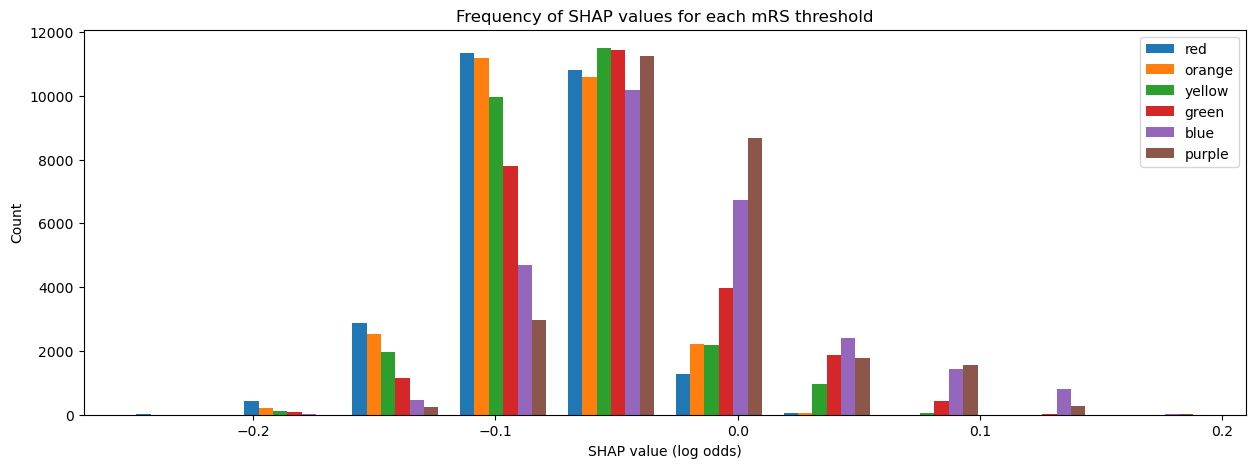

In [ ]:
#fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)
fig, ax = plt.subplots(figsize=(15, 5))
colors = ["red","orange","yellow","green","blue","purple"]
label = ["mRS0","mRS1","mRS2","mRS3","mRS4","mRS5"]
ax.hist(np.array(df_not_ivt_shap_hist[label]), 10, histtype='bar', label=label, color=colors)
ax.legend(prop={'size': 10})
ax.set_xlabel("SHAP value (log odds)")
ax.set_ylabel("Count")
ax.set_title('Frequency of SHAP values for each mRS threshold')

In [ ]:
np.array(df_not_ivt_shap_hist[label]).shape

(26773, 6)

In [ ]:
df_not_ivt_shap["shap_ivt"].groupby(["mRS_threshold"])

KeyError: 'mRS_threshold'

In [ ]:
model = LinearRegression(df_ivt_shap["shap_ivt"],df_ivt_shap["onset_to_thrombolysis_time"])

Duration to run notebook

In [ ]:
str(datetime.timedelta(seconds=(time.time()-start_time)))